# NS Shop+편성데이터(NS홈쇼핑) 를 활용하여 방송편성표에 따른
# 판매실적을 예측하고, 최적 수익을 고려한 요일별/ 시간대별 / 카테고리별 편성
# 최적화 방안(모형) 제시

In [279]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC

mpl.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [63]:
실적데이터1 = pd.read_excel(
    r'./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx', header=1)
시청률데이터1 = pd.read_excel(
    r'./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx', header=1)
평가데이터1 = pd.read_excel(
    r'./02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx', header=1)
기온데이터1 = pd.read_excel(
    r'./01_제공데이터/기온.xlsx', header=0, encoding='euc-kr')
강수량데이터1 = pd.read_excel(
    r'./01_제공데이터/강수량.xlsx', header=0, encoding='euc-kr')
풍속데이터1 = pd.read_excel(
    r'./01_제공데이터/풍속.xlsx', header=0, encoding='euc-kr')

In [151]:
# 날씨 데이터 전처리
기온데이터=기온데이터1[['일시','평균최고기온(℃)', '평균최저기온(℃)']] #'평균기온(℃)',
강수량데이터=강수량데이터1[['일시','평균일강수량(mm)']] # ,'최다일강수량(mm)', '1시간최다강수량(mm)'
풍속데이터=풍속데이터1[['일시','최대풍속(m/s)']] # ,'평균풍속(m/s)', '최대순간풍속(m/s)'

기온데이터=기온데이터.sort_values(by='일시')
강수량데이터=강수량데이터.sort_values(by='일시')
풍속데이터=풍속데이터.sort_values(by='일시')

기온데이터.index=list(range(365))
강수량데이터.index=list(range(365))
풍속데이터.index=list(range(365))

기온데이터.일시=기온데이터.일시.map(lambda x : str(x).split(" ")[0])
강수량데이터.일시=강수량데이터.일시.map(lambda x : str(x).split(" ")[0])
풍속데이터.일시=pd.to_datetime(풍속데이터.일시).map(lambda x : str(x).split(" ")[0])

강수량데이터.fillna(0, inplace=True)

In [325]:
실적데이터=실적데이터1.copy()
시청률데이터=시청률데이터1.copy()
평가데이터=평가데이터1.copy()

# 데이터 전처리
실적데이터.rename(columns={'노출(분)' : '노출'}, inplace=True)

# 결측값 처리 
# 1. 판매단가가 0인 데이터 제거
실적데이터.취급액.fillna(0, inplace=True)

# 2. 노출값이 nan인 항목은 바로 위 항목으로 채우기
실적데이터.노출.fillna(method='ffill', inplace=True)

실적데이터=실적데이터[실적데이터.방송일시<'2020-01-01']

# 주문량 = 취급액 / 판매단가 round(x[1]/x[0], 3) if x[0]!=0 else 0
실적데이터['주문량'] = (실적데이터.취급액/실적데이터.판매단가).fillna(0)

# 날짜 컬럼 나누기
실적데이터['월']=실적데이터.방송일시.dt.month
실적데이터['일']=실적데이터.방송일시.dt.day
실적데이터['요일']=실적데이터.방송일시.dt.weekday
실적데이터['주']=실적데이터.방송일시.dt.week
실적데이터['시간']=실적데이터.방송일시.dt.time
실적데이터['시']=실적데이터.방송일시.dt.hour
실적데이터['분']=실적데이터.방송일시.dt.minute

# 실적데이터['시간'] = 실적데이터.시간.apply(lambda x : str(x)).apply(lambda x : int(x.split(':')[0])*60 + int(x.split(':')[1]))

실적데이터['방송날짜'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])
실적데이터['방송시간'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:-3])

In [153]:
# 시청률데이터 전처리
시청률데이터.set_index('시간대', inplace=True)
시청률데이터.rename(columns={'2019-01-01 to 2019-12-31' : '년평균'}, inplace=True)
시청률데이터.rename(index={'월화수목금토일02:00-01:59' : '일평균'}, inplace=True)
시청률데이터2 = 시청률데이터.loc[:"01:59",:"2019-12-31"]

KeyError: "None of ['시간대'] are in the columns"

38300

In [329]:
# 각 방송일시별 분당평균시청률 구하기
분당평균시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:-3]
    분당평균시청률.append((시청률데이터1[실적데이터.방송날짜.iloc[i]].loc[시작:종료].mean()))
    
분당최고시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:-3]
    분당최고시청률.append((시청률데이터1[실적데이터.방송날짜.iloc[i]].loc[시작:종료].max()))

# 분당평균시청률
실적데이터['분당평균시청률']=분당평균시청률
실적데이터['분당최고시청률']=분당최고시청률

76600

In [331]:
실적데이터 = 실적데이터.drop(['방송시간'],axis=1)
실적데이터=실적데이터.rename(columns={'방송날짜':'일시'})

실적데이터=pd.merge(실적데이터, 기온데이터, on='일시')
실적데이터=pd.merge(실적데이터, 강수량데이터, on='일시')
실적데이터=pd.merge(실적데이터, 풍속데이터, on='일시')

In [54]:
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
result=le1.fit_transform(실적데이터.상품군)
실적데이터['상품군라벨']=result

# le2=LabelEncoder()
# result1=le2.fit_transform(실적데이터.상품명)
# 실적데이터['상품명라벨']=result1

In [332]:
# 원핫인코딩
상품군_df=pd.get_dummies(실적데이터.상품군)
실적데이터=pd.concat([실적데이터, 상품군_df],axis=1)
# 실적데이터.drop(['상품군'], axis=1, inplace=True)

In [333]:
# 실적데이터_final.drop(['수목금토'], axis=1, inplace=True)
# 평일(월화수목금)/주말(토일) 
# 요일별 상품군별 평균 주문량의 추세를 비교. 평일(월화수목금)/주말(토일) 컬럼 생성
실적데이터['평일']=실적데이터.요일.map(lambda x : 1 if x in [0,1,2,3,4] else 0)
실적데이터['주말']=실적데이터.요일.map(lambda x :1 if x in [5,6] else 0)

In [334]:
# 시간대별 상품군별 평균 주문량의 추세를 비교. 밤/새벽(19-02), 오전(6-12), 오후(12-19) 컬럼 생성
실적데이터['밤/새벽(19-02)']=실적데이터.시.map(lambda x : 1 if int(str(x).split(" ")[0]) <= 2 or int(str(x).split(" ")[0]) >= 19 else 0)
실적데이터['오전(6-12)']=실적데이터.시.map(lambda x : 1 if 6 <= int(str(x).split(" ")[0]) <= 12 else 0)
실적데이터['오후(12-19)']=실적데이터.시.map(lambda x : 1 if 12 < int(str(x).split(" ")[0]) < 19 else 0)

In [14]:
# 계절, 상하반기
실적데이터['봄']=실적데이터.월.map(lambda x : 1 if x in [3,4,5] else 0)
실적데이터['여름']=실적데이터.월.map(lambda x :  1 if x in [6,7,8] else 0)
실적데이터['가을']=실적데이터.월.map(lambda x :  1 if x in [9,10,11] else 0)
실적데이터['겨울']=실적데이터.월.map(lambda x :  1 if x in [12,1,2] else 0)
실적데이터['상반기']=실적데이터.월.map(lambda x : 1 if  x in [1,2,3,4,5,6] else 0)
실적데이터['하반기']=실적데이터.월.map(lambda x : 1 if  x in [7,8,9,10,11,12] else 0)
# 실적데이터_final.drop(['봄','여름','가을','겨울', '상반기','하반기'], axis=1, inplace=True)

In [20]:
# 노출
실적데이터['노출20미만']=실적데이터.노출.map(lambda x : 1 if x < 20 else 0)
실적데이터['노출20이상']=실적데이터.노출.map(lambda x : 1 if 20 <= x < 30 else 0)
실적데이터['노출30이상']=실적데이터.노출.map(lambda x : 1 if x >= 30 else 0)

In [21]:
# 168시간 기준
실적데이터['168시간기준']=실적데이터.방송일시.dt.weekday*24+실적데이터.방송일시.dt.hour

In [336]:
실적데이터_temp=실적데이터_final.copy()
브랜드_df=pd.get_dummies(실적데이터_temp.브랜드)
실적데이터_temp=pd.concat([실적데이터_temp, 브랜드_df],axis=1)

In [335]:
# 브랜드 컬럼

# 상품명에서 불필요한 단어 제거
list1 = []
for item in 실적데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# 숫자, 영어, 한글을 제외한 문자 제거
list3 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list3.append(result_string.strip())

# 주로 브랜드명이 첫 어절에 온다고 판단. 첫 어절로 브랜드 컬럼 생성
list4 = []
for item in list3:
    list4.append(item.split(" ")[0])
실적데이터['브랜드'] = pd.Series(list4)

# 브랜드별 점수 매기기
# 브랜드별 평균 주문량 계산
df_temp = 실적데이터.pivot_table(
    index=['브랜드'], values='주문량', aggfunc='mean').sort_values(by='주문량', ascending=False)
# minmaxscaler로 0~1 사이값으로 scale 조정
df_temp1 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp), index=df_temp.index)

# 브랜드별 평균 주문량을 scale 조절한 값을 브랜드 점수로 산정. 브랜드점수 컬럼 생성
df_temp1 = df_temp1.reset_index()
실적데이터 = pd.merge(실적데이터, df_temp1, on='브랜드')
실적데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)

In [367]:
df_temp1.head(20)

,브랜드,브랜드점수
0,고창,1.000000
1,완도꼬마활전복,0.908812
2,영산포숙성홍어회7팩,0.679749
3,우리바다,0.595504
4,안동간고등어,0.546761
5,강원도양구,0.520301
6,참바다손질낙지100미양념장연포탕육수,0.472322
7,코튼데이,0.456129
8,궁중,0.451839
9,특등급,0.448762


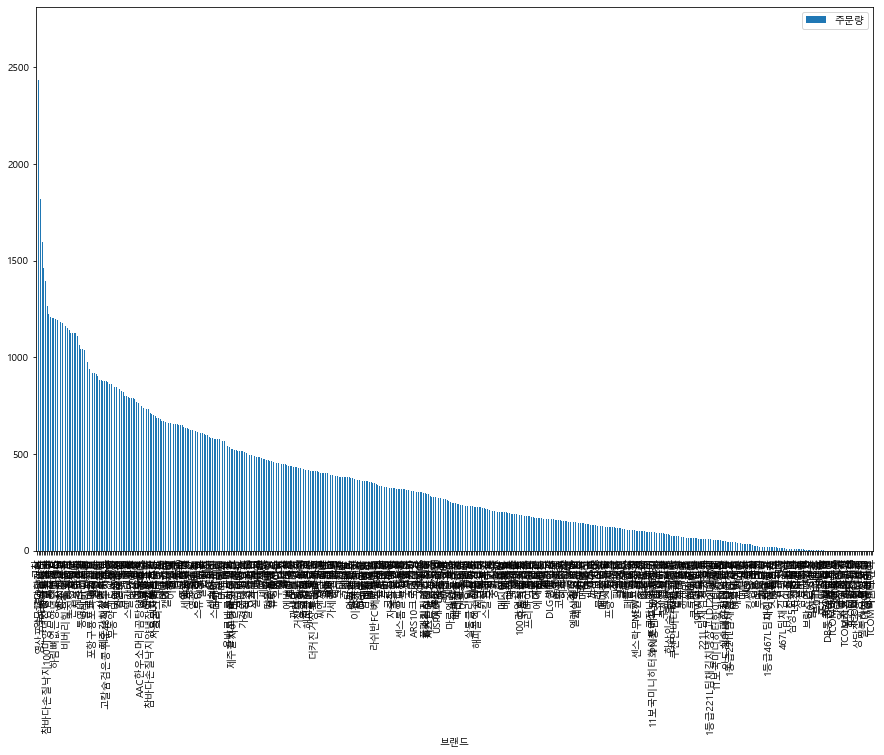

In [363]:
실적데이터.pivot_table(index=['브랜드'],values='주문량', aggfunc='mean').sort_values(by='주문량', ascending=False).plot(figsize=(15,10), kind='bar')

In [336]:
실적데이터_feature = 실적데이터.drop(['취급액', '방송일시', '상품명', '주문량', '브랜드', '일시', '시간','상품군','분당평균시청률'], axis=1)
실적데이터_target= 실적데이터['주문량']

마더코드_df=pd.get_dummies(실적데이터_feature.마더코드)
마더코드=[]
for i in 마더코드_df.columns:
    마더코드.append(str(i)+'마더코드')
마더코드_df.columns=마더코드
실적데이터_feature=pd.concat([실적데이터_feature, 마더코드_df],axis=1)

상품코드_df=pd.get_dummies(실적데이터_feature.상품코드)
상품코드=[]
for i in 상품코드_df.columns:
    상품코드.append(str(i)+'상품코드')
상품코드_df.columns=상품코드
실적데이터_feature=pd.concat([실적데이터_feature, 상품코드_df],axis=1)

월_df=pd.get_dummies(실적데이터_feature.월)
월=[]
for i in 월_df.columns:
    월.append(str(i)+'월')
월_df.columns=월
실적데이터_feature=pd.concat([실적데이터_feature, 월_df],axis=1)

일_df=pd.get_dummies(실적데이터_feature.일)
일=[]
for i in 일_df.columns:
    일.append(str(i)+'일')
일_df.columns=일
실적데이터_feature=pd.concat([실적데이터_feature, 일_df],axis=1)

요일_df=pd.get_dummies(실적데이터_feature.요일)
요일=[]
for i in 요일_df.columns:
    요일.append(str(i)+'요일')
요일_df.columns=요일
실적데이터_feature=pd.concat([실적데이터_feature, 요일_df],axis=1)

주_df=pd.get_dummies(실적데이터_feature.주)
주=[]
for i in 주_df.columns:
    주.append(str(i)+'주')
주_df.columns=주
실적데이터_feature=pd.concat([실적데이터_feature, 주_df],axis=1)

시_df=pd.get_dummies(실적데이터_feature.시)
시=[]
for i in 시_df.columns:
    시.append(str(i)+'시')
시_df.columns=시
실적데이터_feature=pd.concat([실적데이터_feature, 시_df],axis=1)

분_df=pd.get_dummies(실적데이터_feature.분)
분=[]
for i in 분_df.columns:
    분.append(str(i)+'분')
분_df.columns=분
분_df['25분']=[0 for i in range(38300)]
분_df['55분']=[0 for i in range(38300)]
분_df=분_df[[str(i)+"분" for i in range(0,60,5)]]
실적데이터_feature=pd.concat([실적데이터_feature, 분_df],axis=1)


실적데이터_feature.판매단가=실적데이터_feature.판매단가/100000

# 판매단가_df=pd.get_dummies(실적데이터_feature.판매단가)
# 판매단가=[]
# for i in 판매단가_df.columns:
#     판매단가.append(str(i)+'원')
# 판매단가_df.columns=판매단가
# 실적데이터_feature=pd.concat([실적데이터_feature, 판매단가_df],axis=1)


실적데이터_feature = 실적데이터_feature.drop(['마더코드', '상품코드', '월', '일', '요일', '주' , '시', '분'], axis=1)

In [337]:
X=실적데이터_feature.copy()
y=실적데이터_target.copy()

In [315]:
# X.drop(['밤/새벽(19-02)','오전(6-12)','오후(12-19)'], axis=1, inplace=True)
# X.drop(['주말','평일'], axis=1, inplace=True)

In [313]:
X['밤/새벽(19-02)']

0        0
1        0
2        0
3        0
4        0
        ..
38295    1
38296    1
38297    0
38298    0
38299    0
Name: 밤/새벽(19-02), Length: 38300, dtype: int64

# 학습/분석

통계

In [14]:
# 통계
pd.options.display.float_format = '{:.5f}'.format

시간별 상품군별 주문량 비교

In [114]:
상품별_주문량_시=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='mean')
상품별_갯수_시=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='count')

In [98]:
상품별_주문량_시

상품군,가구,가전,건강기능,농수축,무형,생활용품,속옷,의류,이미용,잡화,주방,침구
시,,,,,,,,,,,,
0,1860.561076,946.489249,5838.523187,11948.123968,0.0,25610.420482,87605.434499,90228.135217,43240.106296,29390.443265,5381.378805,356.722166
1,1241.242472,59.803198,4143.046201,39397.804806,0.0,23657.973648,66214.976659,56380.784037,35691.528463,30654.334525,2832.912035,2128.120284
2,3.891462,NaN,852.572810,2772.494583,0.0,2248.517581,2993.899578,2213.526695,3905.126344,988.295910,610.865971,294.159850
6,145.474703,NaN,21794.520754,6084.434353,0.0,37023.428537,54477.694192,114261.310608,24250.321674,30791.478729,37326.513748,1356.654987
7,83.222810,198.409566,71830.106966,10992.196587,0.0,33699.873331,80691.687269,180908.836665,41644.673286,89696.293127,64260.353240,NaN
8,143.040354,699.765809,25128.521245,3537.679466,0.0,38797.353711,87264.106233,192929.684312,52522.564109,82245.231221,78248.404646,308.340016
9,NaN,744.782390,20993.213184,13419.495766,0.0,34737.541874,78883.930033,194826.707079,67742.966094,100774.118456,111574.092187,NaN
10,203.004964,2539.131624,13864.793573,178727.437253,0.0,19115.275943,69268.652971,120082.023293,36689.541229,89356.183188,99136.464078,2163.842577
11,NaN,1558.838419,9371.397710,242846.975044,0.0,12572.284596,102491.056532,76999.791181,20991.881762,85987.401793,87565.004812,19165.200823


In [110]:
상품별_갯수_시

상품군,가구,가전,건강기능,농수축,무형,생활용품,속옷,의류,이미용,잡화,주방,침구
시,,,,,,,,,,,,
0,114.0,92.0,21.0,6.0,243.0,230.0,290.0,345.0,63.0,256.0,67.0,8.0
1,19.0,14.0,37.0,84.0,55.0,210.0,386.0,283.0,135.0,269.0,37.0,75.0
2,2.0,NaN,5.0,4.0,2.0,15.0,10.0,9.0,10.0,8.0,3.0,4.0
6,36.0,NaN,105.0,20.0,8.0,210.0,197.0,361.0,88.0,121.0,197.0,18.0
7,20.0,28.0,194.0,18.0,6.0,156.0,197.0,376.0,79.0,229.0,178.0,NaN
8,10.0,12.0,55.0,5.0,10.0,185.0,203.0,364.0,73.0,397.0,324.0,6.0
9,NaN,70.0,43.0,13.0,3.0,128.0,144.0,383.0,87.0,394.0,337.0,NaN
10,18.0,220.0,22.0,182.0,2.0,80.0,131.0,286.0,38.0,431.0,544.0,9.0
11,NaN,93.0,22.0,253.0,3.0,85.0,174.0,215.0,24.0,434.0,477.0,96.0


In [115]:
상품별_주문량_시.fillna(0, inplace=True)
상품별_갯수_시.fillna(0, inplace=True)

In [239]:
temp1=상품별_주문량_시.loc[6:23]
temp2=상품별_주문량_시.loc[0:2]
상품별_주문량_시=pd.concat([temp1,temp2], axis=0)

In [246]:
temp1=상품별_갯수_시.loc[6:23]
temp2=상품별_갯수_시.loc[0:2]
상품별_갯수_시=pd.concat([temp1,temp2], axis=0)

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


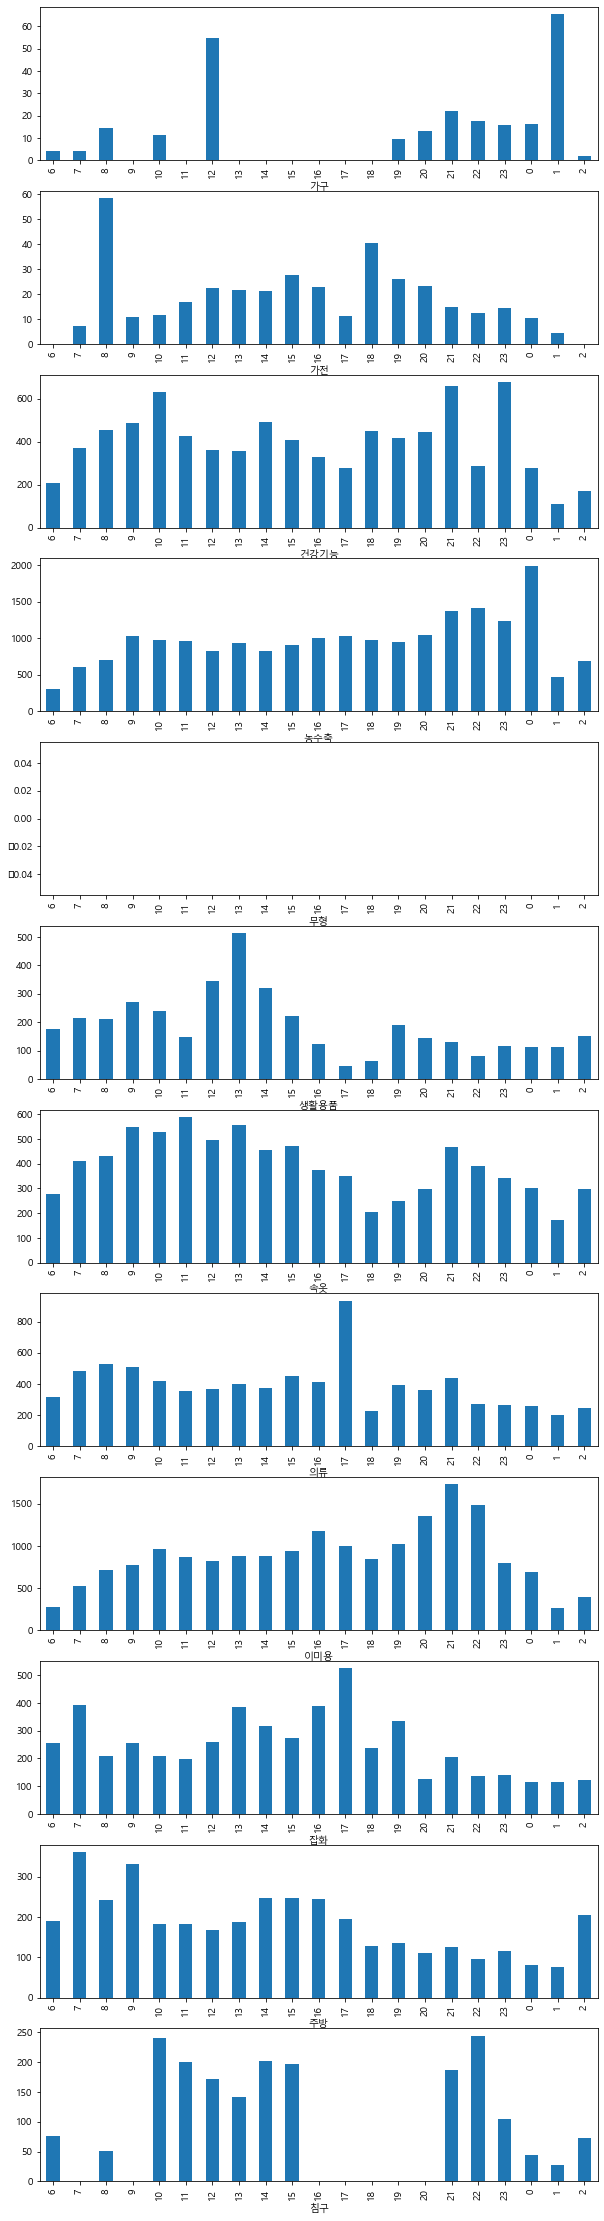

In [249]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_주문량_시.columns)):
    plt.subplot(12,1,i+1)
    상품별_주문량_시[item].plot(kind='bar')
    plt.xlabel(item)
plt.savefig('상품별 시간별 평균 주문량.png')

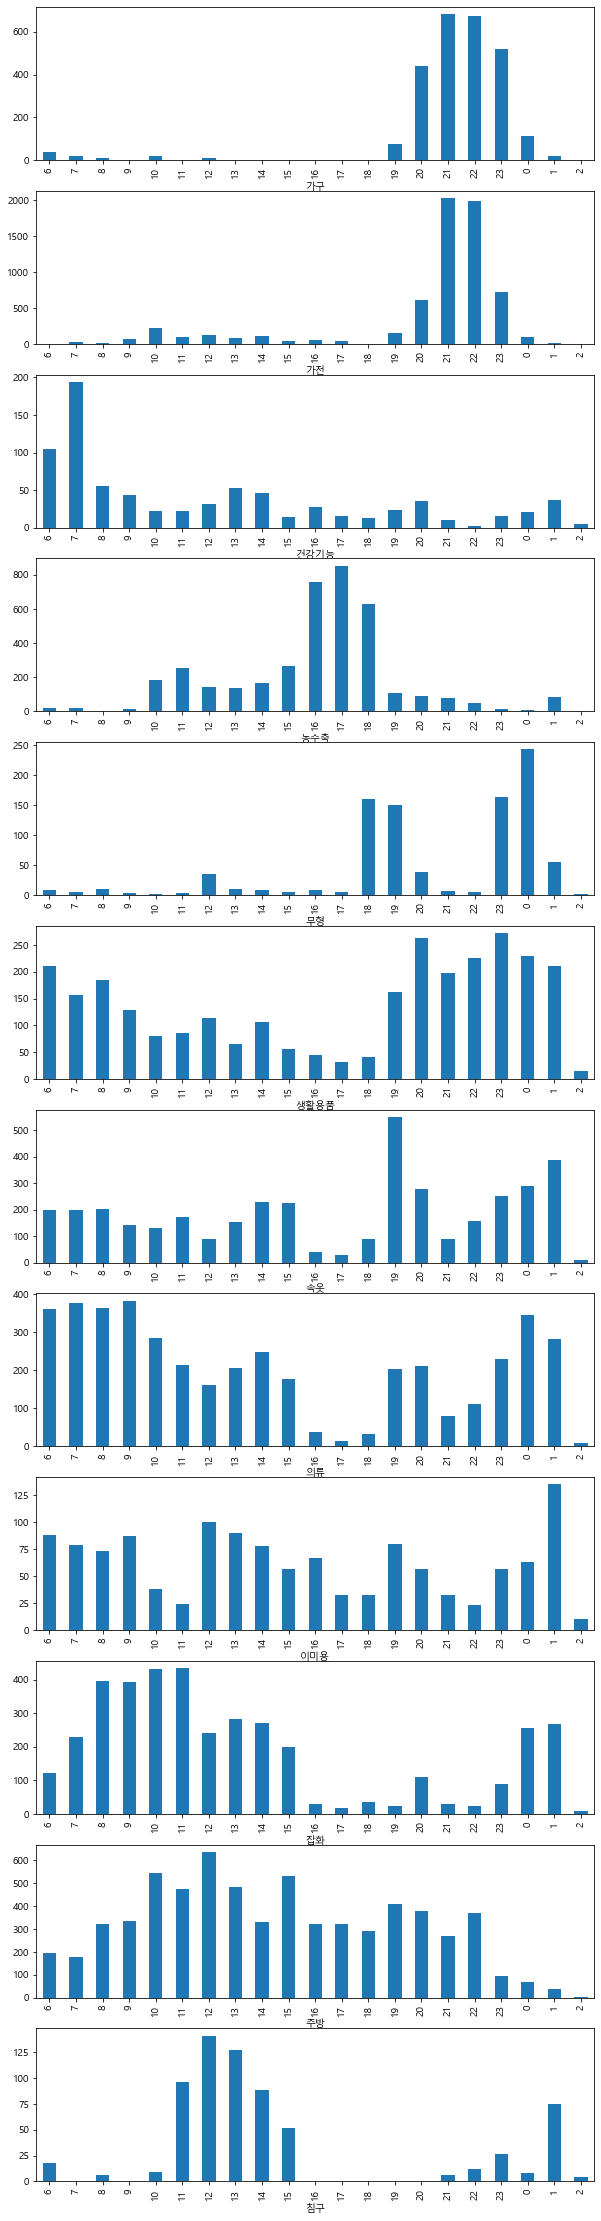

In [248]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_갯수_시.columns)):
    plt.subplot(12,1,i+1)
    상품별_갯수_시[item].plot(kind='bar')
    plt.xlabel(item)
plt.savefig('상품군별 시간별 방송횟수.png')

2시는 대체적으로 주문량이 없음
시간별 평균 주문량은 시간별 방송 편성 수와 반대되는 결과를 가져왔다.

In [121]:
상품별_주문량_시_max=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='max')
# 상품별_갯수_시=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='count')
상품별_주문량_시_max.fillna(0, inplace=True)

NameError: name '상품별_주문량_시_max' is not defined

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


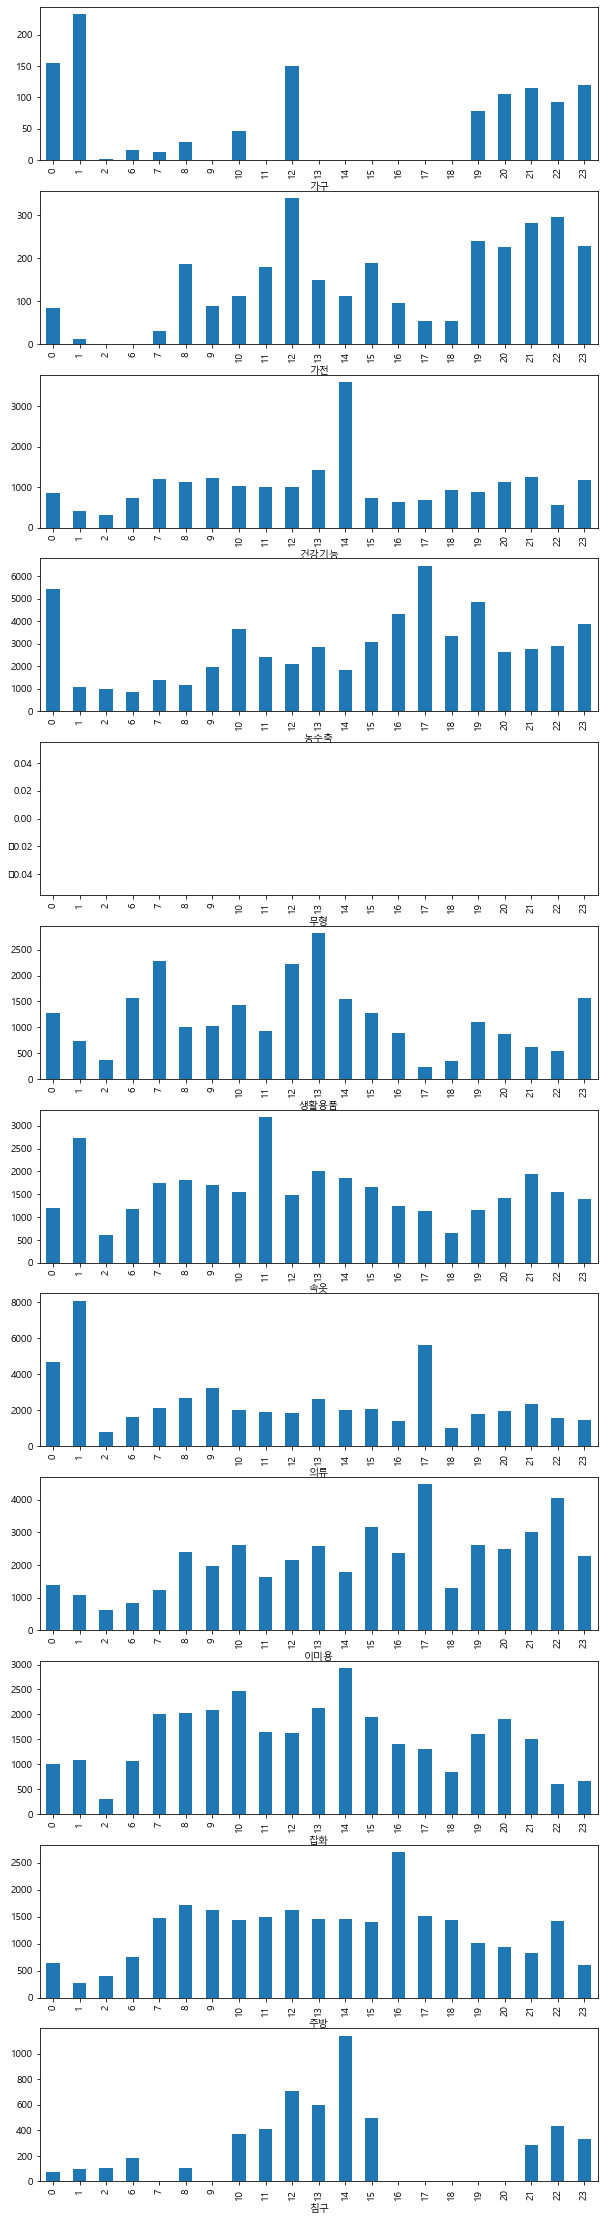

In [122]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_주문량_시_max.columns)):
    plt.subplot(12,1,i+1)
    상품별_주문량_시_max[item].plot(kind='bar')
    plt.xlabel(item)

요일별 상품군별 주문량 비교

In [209]:
상품별_주문량_요일=실적데이터.pivot_table(index=['요일'],columns='상품군',values='주문량', aggfunc='mean')
상품별_주문량_요일.fillna(0, inplace=True)

In [210]:
상품별_주문량_요일

상품군,가구,가전,건강기능,농수축,무형,생활용품,속옷,의류,이미용,잡화,주방,침구
요일,,,,,,,,,,,,
0,17.165490,19.835873,325.735988,920.261689,0.0,164.230631,364.022796,328.748482,759.463268,224.527837,186.159851,162.781701
1,17.781204,14.639635,353.040443,964.303467,0.0,163.324290,343.295066,383.027460,677.075951,233.646933,159.189619,137.945299
2,14.992211,15.814613,329.526396,915.298556,0.0,212.143027,363.364768,355.292552,762.687780,234.727610,178.336683,115.060946
3,19.828954,13.902714,368.608760,934.835982,0.0,177.609571,397.828413,393.440732,636.583052,235.601951,180.743430,148.970540
4,17.646912,14.537365,364.603494,902.935594,0.0,187.305537,318.556029,399.371795,651.575923,219.482643,174.090679,213.000843
5,19.026889,14.409463,482.335300,1112.161688,0.0,164.393693,393.757194,409.706778,949.418395,221.107004,263.407580,322.995400
6,16.191769,16.002003,469.925967,1107.421211,0.0,147.215977,374.762840,402.637259,1138.382194,319.450615,213.915601,172.002816


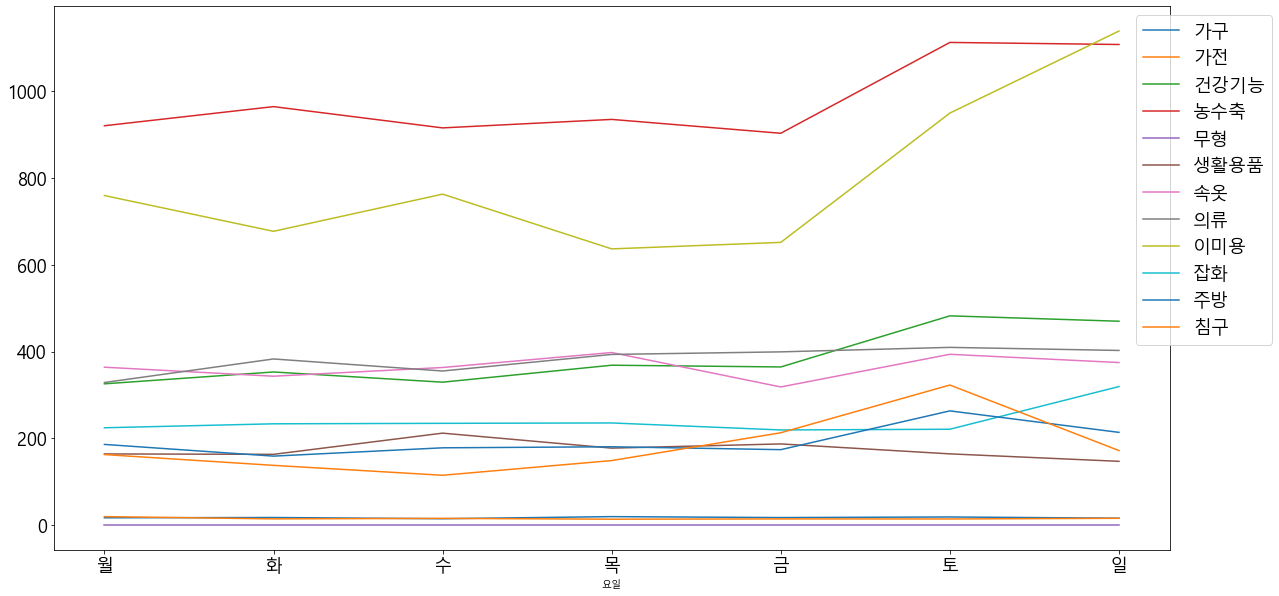

In [235]:
# for i, item in enumerate(list(상품별_주문량_요일.columns)):
#     plt.subplot(12,1,i+1)
상품별_주문량_요일.plot(kind='line',figsize=(20,10), fontsize=18)
# plt.xlabel(상품별_주문량_요일.index)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)
plt.xticks([0,1,2,3,4,5,6],['월','화','수','목','금','토','일'])
plt.savefig('상품군별 요일별 평균 주문량.png')

In [127]:
브랜드별_주문량=실적데이터.pivot_table(index=['브랜드'],columns='상품군',values='주문량', aggfunc='mean')
브랜드별_주문량.fillna(0, inplace=True)

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


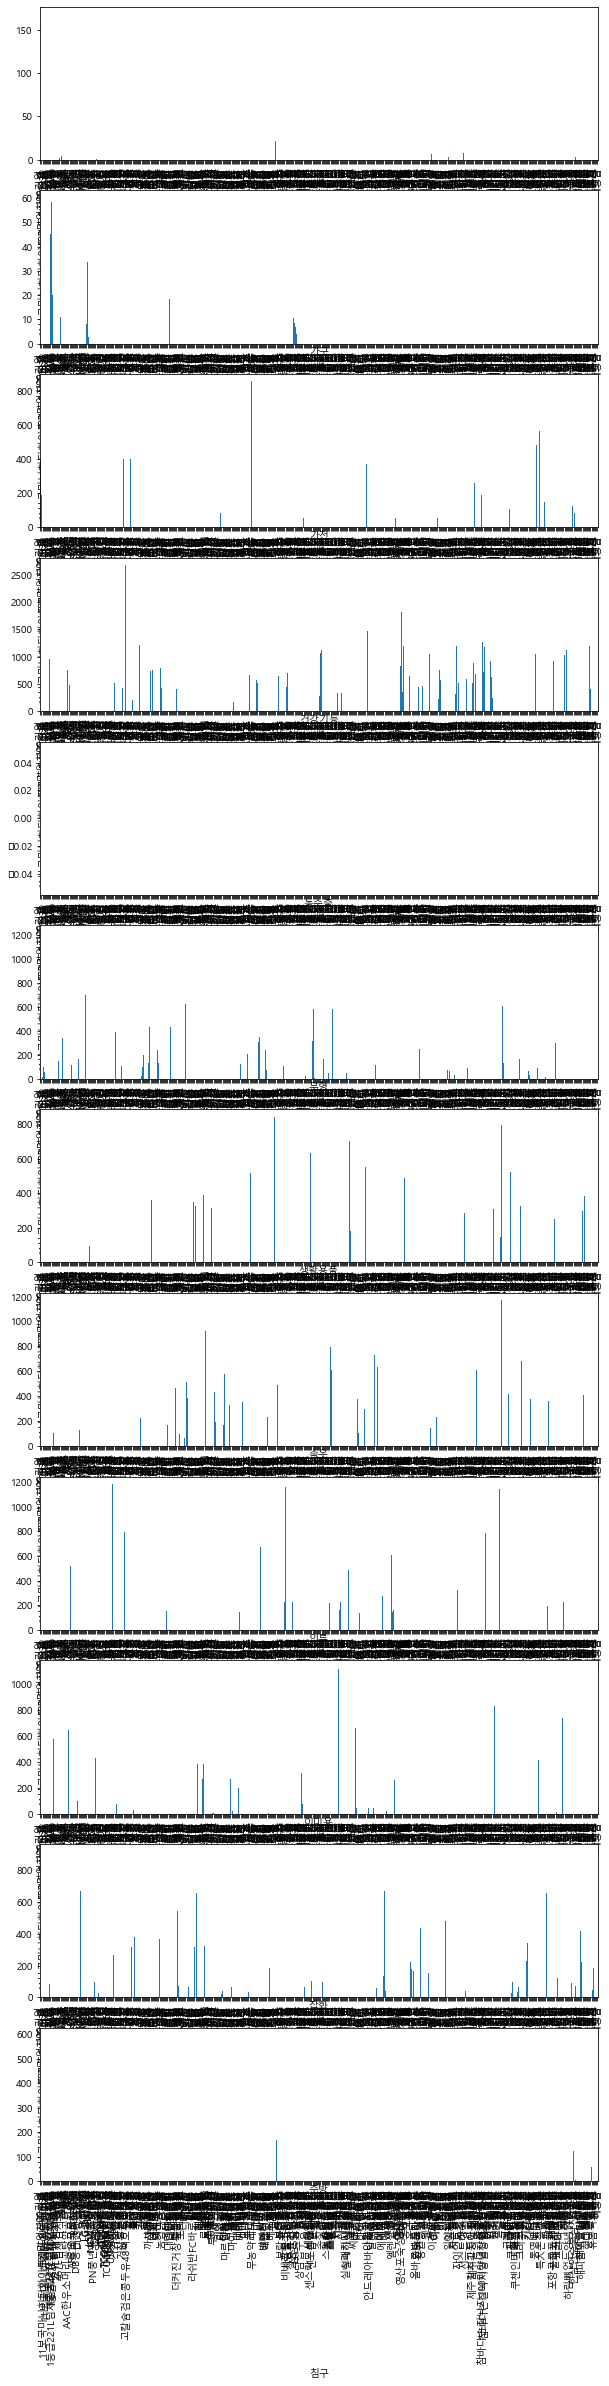

In [129]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(브랜드별_주문량.columns)):
    plt.subplot(12,1,i+1)
    브랜드별_주문량[item].plot(kind='bar')
    plt.xlabel(item)

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 51068 missing from current font.
  font.load_char(ord(s), flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
G:\Anaconda\lib\site-packages

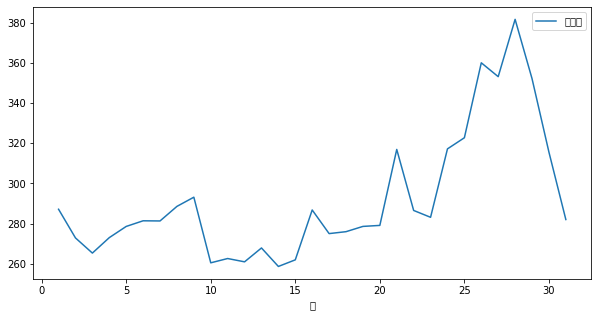

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 50900 missing from current font.
  font.load_char(ord(s), flags=flags)


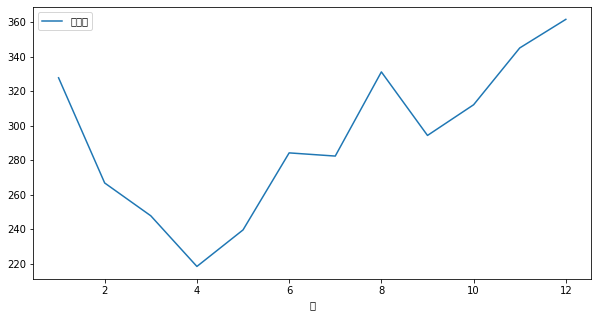

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)


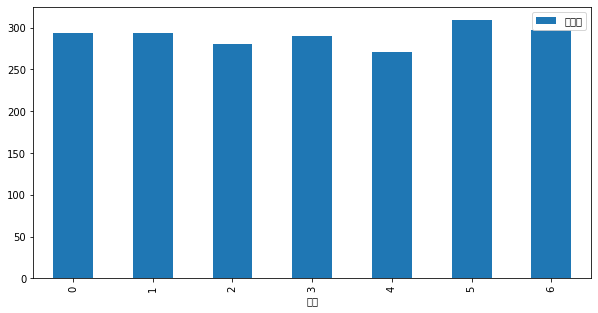

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0, flags=flags)


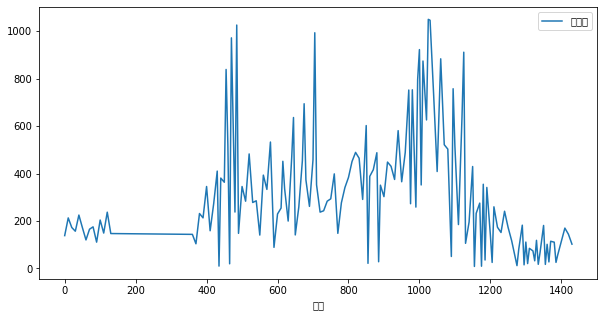

In [297]:
실적데이터.pivot_table(index=['일'],values='주문량', aggfunc='mean').plot(figsize=(10,5), kind='line')
실적데이터.pivot_table(index=['월'],values='주문량', aggfunc='mean').plot(figsize=(10,5), kind='line')
실적데이터.pivot_table(index=['요일'],values='주문량', aggfunc='mean').plot(figsize=(10,5), kind='bar')
실적데이터.pivot_table(index=['시'],values='주문량', aggfunc='mean').plot(figsize=(10,5), kind='line')

In [ ]:
실적데이터_final.pivot_table(index=['시간'],columns='상품군',values='주문량', aggfunc='sum')['가전'].plot(figsize=(10,5), kind='bar')
실적데이터_final.pivot_table(index=['시간'],columns='상품군',values='주문량', aggfunc='mean')['가전'].plot(figsize=(10,5), kind='bar')

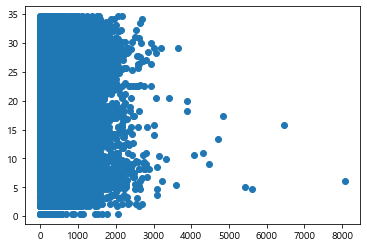

In [344]:
plt.scatter(실적데이터.주문량, 실적데이터['평균최고기온(℃)'])

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


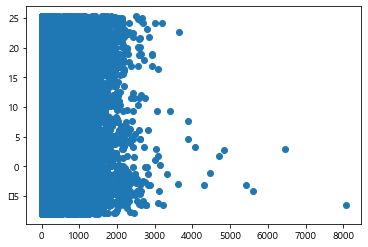

In [345]:
plt.scatter(실적데이터.주문량, 실적데이터['평균최저기온(℃)'])

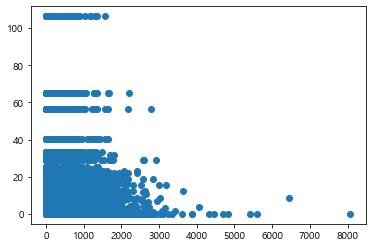

In [346]:
plt.scatter(실적데이터.주문량, 실적데이터['평균일강수량(mm)'])

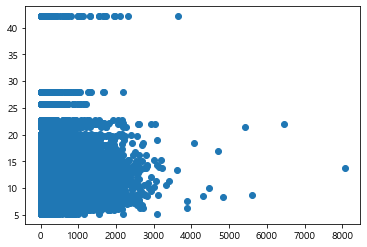

In [348]:
plt.scatter(실적데이터.주문량, 실적데이터['최대풍속(m/s)'])

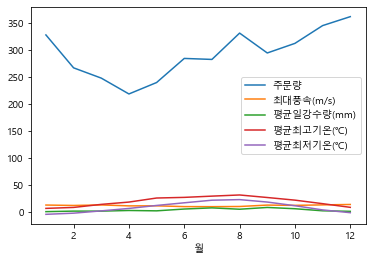

In [357]:
temp1=실적데이터.pivot_table(index=['월'],values=['평균최고기온(℃)','평균최저기온(℃)','평균일강수량(mm)','최대풍속(m/s)','주문량'], aggfunc='mean').plot()


# XGBOOST

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

xgb_reg = XGBRegressor(n_estimator = 500, gamma=0, learning_rate=0.4, max_depth=10, n_jobs=-1, objective ='reg:squarederror')
# xgb_reg = XGBClassifier(n_estimator = 1000)

xgb_reg.fit(X_train, y_train) # early_stopping_rounds=200,
         # eval_set = [(X_test, y_test)], eval_metric='logloss')

xgb_reg.score(X_test, y_test)

0.8935469421768583

In [237]:
y_pred=xgb_reg.predict(X_test)
r2=mt.r2_score(y_test,y_pred)
print('r2 : ', r2)
print(y_pred)

r2 :  0.8857520285225767
[  41.435776   298.73483    229.42598   ...    4.421024  1242.0743
    4.4752407]


In [ ]:
0.8903476400379359 # 판매단가단위 낮추기
0.8962178104464822 # 주말/평일 + 시간3분할
0.8935469421768583 # 주말/평일 + 시간3분할 + 분당최고시청률
0.8913188169704233 # 주말/평일
0.8903476400379359 # 시간3분할
0.8916336546153545 # 파생없이


# svm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)


svm_reg = SVR(kernel="rbf", C=150, gamma=0.5, max_iter=-1)
svm_reg.fit(X_train, y_train)

y_pred = svm_reg.predict(X_test)

mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

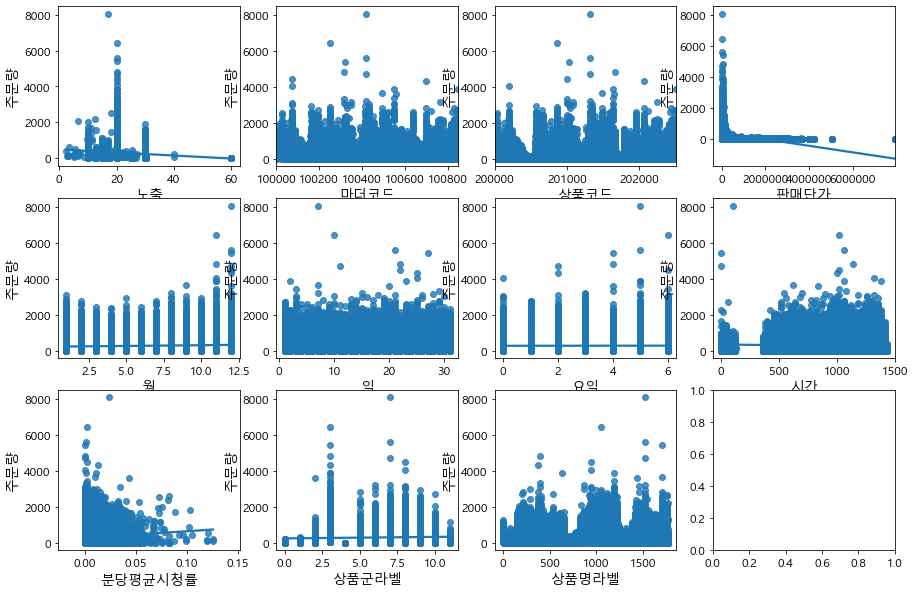

In [615]:
fig, axs = plt.subplots(figsize=(15,10), nrows=3, ncols=4)

for i, feature in enumerate(['노출', '마더코드', '상품코드', '판매단가', '월', '일', '요일',
       '시간', '분당평균시청률', '상품군라벨', '상품명라벨']):
    r = int(i/4)
    c = i%4
    sns.regplot(x=feature, y='주문량', data=실적데이터, ax=axs[r][c])



# 선형회귀

In [370]:
from sklearn.linear_model import LinearRegression


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

3.0094229877874e+31 5485820802566741.0 -1.7279304297697174e+26


# 시계열성 조사

In [618]:
temp=실적데이터_final[['방송일시','주문량']]
temp.set_index('방송일시', inplace=True)
temp

,분당평균시청률
방송일시,
2019-01-01 06:00:00,0.00000
2019-01-01 06:00:00,0.00000
2019-01-01 06:20:00,0.00000
2019-01-01 06:20:00,0.00000
2019-01-01 06:40:00,0.00000
...,...
2019-12-31 23:20:00,0.00000
2019-12-31 23:40:00,0.02060
2019-12-31 23:40:00,0.02060


In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

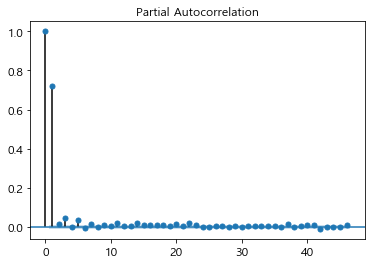

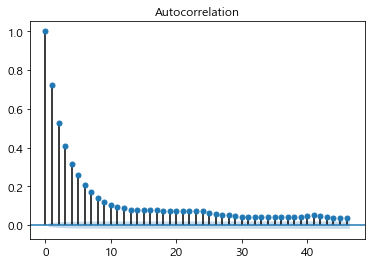

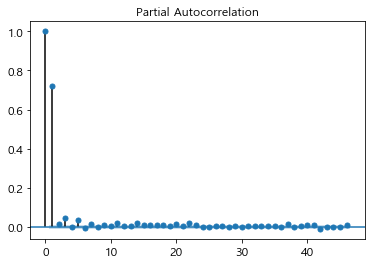

In [620]:
plot_acf(temp)
plot_pacf(temp)

# 다층신경망

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

In [461]:
X=실적데이터_final_df.drop(['취급액'], axis=1)
y=실적데이터_final_df['취급액']
X_train, X_test, y_train, y_test = train_test_split(X,y)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=200, solver='adam')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(y_pred)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

G:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[  68.9957217   506.73024355  813.11448224 ...   23.17368063   26.96283346
 1519.95966321]
24982.018404709623 158.05700998282114 0.861196545569298


In [ ]:
24982.018404709623 158.05700998282114 0.861196545569298

# GridSearchCV

In [173]:
from sklearn.model_selection import GridSearchCV

In [674]:
mlp = MLPRegressor(solver='lbfgs')
mlp_params={
    'hidden_layer_sizes' : [(10,10,10),(100,100,100),(200,200,200)],
    'max_iter' : [100,200,300]
}

In [175]:
XGBReg=XGBRegressor( n_jobs=-1)
XGB_params={
    'n_estimator' : [100,300,500], 'gamma':[0,0.1,0.2], 'learning_rate':[0.3,0.4,0.5], 'max_depth':[5,10,15]
}

In [176]:
grid_rf = GridSearchCV(XGBReg, param_grid=XGB_params, cv = 5)

In [177]:
grid_rf.fit(X_train, y_train)
grid_rf.score(X_test, y_test)

[18:20:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:46:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:54:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:55:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:02:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.8635913179099051

In [182]:
print('학습데이터 정확도 ', grid_rf.score(X_train, y_train))
print('테스트데이터 정확도 {:.2f}'.format(grid_rf.score(X_test, y_test)))

학습데이터 정확도  0.9894742456727855
테스트데이터 정확도 0.86


In [191]:
grid_rf.best_estimator_

XGBRegressor(gamma=0.1, learning_rate=0.3, max_depth=10, n_estimator=100,
             n_jobs=-1)

# 심층신경망 - LSTM

In [67]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping 
import tensorflow as tf
tf.config.run_functions_eagerly(True)


In [74]:
# tf.config.experimental_run_functions_eagerly(False)

In [626]:
X=실적데이터_final[['방송일시','노출', '마더코드', '상품코드', '판매단가', '월', '일', '요일',
       '시간', '분당평균시청률', '상품군라벨', '상품명라벨']]
y=실적데이터_final[['방송일시','주문량']]
X.set_index('방송일시', inplace=True)
y.set_index('방송일시', inplace=True)

In [631]:
ts = 12

y["std_value"] = y.주문량.map(lambda x : (x - y.주문량.mean()) / np.std(y.주문량))
X_train = np.asarray([np.array([y.주문량.values[i+j] for j in range(ts)])
                      for i in range(len(y.주문량) - ts)]).reshape(-1,ts,1)
y_train = y.std_value.values[ts:]
X_train.shape, y_train.shape

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


((38288, 12, 1), (38288,))

In [346]:
# scaler = MinMaxScaler()

# X1=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(100, input_shape=(12,1))) # (timestep, feature) 
model.add(Dense(1) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam')

In [128]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [130]:
history_model = model.fit(X_train, y_train, epochs=10, verbose=2)

G:\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
898/898 - 30s - loss: 650.7198
Epoch 2/10
898/898 - 31s - loss: 650.4584
Epoch 3/10
898/898 - 30s - loss: 650.4582
Epoch 4/10
898/898 - 30s - loss: 650.4582
Epoch 5/10
898/898 - 30s - loss: 650.4583
Epoch 6/10
898/898 - 31s - loss: 650.4581
Epoch 7/10
898/898 - 32s - loss: 650.4580
Epoch 8/10
898/898 - 33s - loss: 650.4584
Epoch 9/10
898/898 - 31s - loss: 650.4579
Epoch 10/10
898/898 - 30s - loss: 650.4578


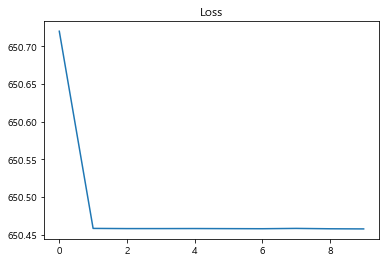

In [131]:
plt.plot(history_model.history["loss"])
plt.title("Loss")
plt.show()

IndexError: too many indices for array

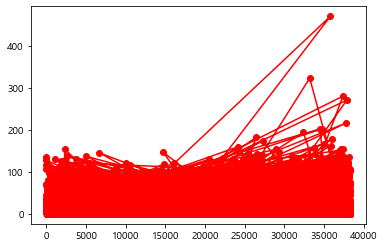

In [132]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("학습 후")
plt.show()

In [134]:
y_pred=model.predict(X_train)
mse = mt.mean_squared_error(y_train[:], y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_train[:], y_pred)
print(mse, rmse, r2)

G:\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


650.4581102617132 25.504080266924216 -0.40706859977022414


# 상품명 단어별 컬럼화

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

In [37]:
t=Tokenizer()
t.fit_on_texts(실적데이터_final.상품명)
di={}
for k,v in t.word_index.items():
    di[v]=k
a=list(di.keys())
b=len(a)
c=len(실적데이터_final)
temp=[[0 for i in range(b)] for i in range(c)]
상품명컬럼 = pd.DataFrame(temp, columns=a)


In [38]:
상품명컬럼

,1,2,3,4,5,6,7,8,9,10,...,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38306,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# 상품명컬럼 값 변경
encoded=t.texts_to_sequences(실적데이터_final.상품명)
for i,item in enumerate(encoded):
    for j in item:
        상품명컬럼[j].iloc[i]=1

In [41]:
# 컬럼 합치기
실적데이터_final_df=pd.concat([실적데이터_final, 상품명컬럼],axis=1)
실적데이터_final_df.drop(['상품명'], axis=1, inplace=True)
실적데이터_final_df

,방송일시,노출,마더코드,상품코드,상품군,판매단가,취급액,월,일,요일,...,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532
0,2019-01-01 06:00:00,20.00000,100346,201072,의류,39900,2099000.00000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 06:00:00,20.00000,100346,201079,의류,39900,4371000.00000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 06:20:00,20.00000,100346,201072,의류,39900,3262000.00000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 06:20:00,20.00000,100346,201079,의류,39900,6955000.00000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 06:40:00,20.00000,100346,201072,의류,39900,6672000.00000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20.00000,100073,200196,무형,0,0.00000,1,1,2,...,0,0,0,0,0,0,0,0,0,0
38305,2020-01-01 00:40:00,20.00000,100073,200196,무형,0,0.00000,1,1,2,...,0,0,0,0,0,0,0,0,0,0
38306,2020-01-01 01:00:00,20.00000,100073,200196,무형,0,0.00000,1,1,2,...,0,0,0,0,0,0,0,0,0,0
38307,2020-01-01 01:20:00,20.00000,100490,201478,무형,0,0.00000,1,1,2,...,0,0,0,0,1,1,1,0,0,0


In [42]:
실적데이터_final_df.drop(['상품군'], axis=1, inplace=True)

In [46]:
실적데이터_final_df.drop(['방송일시'], axis=1, inplace=True)

In [415]:
pd.DataFrame(to_categorical(X.상품군라벨))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
38295,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
38296,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
38297,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
38298,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000


# 신경망

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[11]),
#     keras.layers.Dense(300, kernel_initializer="he_normal"),
#     keras.layers.LeakyReLU(),
#     keras.layers.Dense(100),
#     keras.layers.LeakyReLU(),
#     keras.layers.Dense(1, activation="softmax")
# ])
n=X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=n, kernel_initializer='normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='normal'),
    keras.layers.Dense(1)
])

# model = tf.keras.models.Sequential()
# model.add(tf.keras.Input(shape=X_train.shape[1:]))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [272]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])

In [273]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                191616    
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 193,729
Trainable params: 193,729
Non-trainable params: 0
_________________________________________________________________


In [275]:
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)
# test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
loss_and_metrics = model.evaluate(X_test, y_test)
print(f'\nLoss : {loss_and_metrics[0]:6}')
print(f'mae : {loss_and_metrics[1]:6}')

Epoch 1/20
2298/2298 [==============================] - 4s 2ms/step - loss: 100280.4062 - mae: 189.3746 - val_loss: 50765.4141 - val_mae: 128.3818
Epoch 2/20
2298/2298 [==============================] - 4s 2ms/step - loss: 44099.4023 - mae: 108.5633 - val_loss: 36541.2695 - val_mae: 98.4205
Epoch 3/20
2298/2298 [==============================] - 4s 2ms/step - loss: 35115.4453 - mae: 93.2216 - val_loss: 32368.0938 - val_mae: 89.4478
Epoch 4/20
2298/2298 [==============================] - 4s 2ms/step - loss: 31188.5312 - mae: 86.1899 - val_loss: 30077.7773 - val_mae: 86.1728
Epoch 5/20
2298/2298 [==============================] - 4s 2ms/step - loss: 28934.6152 - mae: 81.9017 - val_loss: 28954.7168 - val_mae: 81.7103
Epoch 6/20
2298/2298 [==============================] - 4s 2ms/step - loss: 27530.4414 - mae: 79.2655 - val_loss: 27950.3477 - val_mae: 80.7072
Epoch 7/20
2298/2298 [==============================] - 4s 2ms/step - loss: 26450.3926 - mae: 77.0056 - val_loss: 26701.3496 - val_m

In [195]:
y_pred=model.predict(X_test)
mt.r2_score(y_test, y_pred)

0.8841370865719258

In [219]:
0.893447742721615 # 노출, 판매단가 컬럼으로 넘겼을때
0.8841370865719258 # 판매단가 단위 변경(100000원단위)

,0
브랜드,
고창,1.000000
완도꼬마활전복,0.908812
영산포숙성홍어회7팩,0.679749
우리바다,0.595504
안동간고등어,0.546761
...,...
대명아임레디,0.000000
참좋은여행,0.000000
메리츠,0.000000


In [396]:
test_mae_score

21126434.0

# Kfold 교차검증

In [385]:
class nn_keras(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.data = None
        self.model = None
        self.result = None
        
    def fit(self, X_train, y_train):
        self.model = keras.models.Sequential([
                keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:], kernel_initializer='normal'),
                keras.layers.Dense(32, activation='relu', kernel_initializer='normal'),
                keras.layers.Dense(1)
            ])
        self.model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])
        self.result = self.model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=1)
        
    def predict(self, new_data):
        return self.result.predict(new_data)

In [386]:
cv = KFold(5, shuffle=True, random_state=0)
model=nn_keras()
results = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
print("Results: %.2f (%.2f) MAE" % (results.mean(), results.std()))
print(results)

Epoch 1/20
1839/1839 [==============================] - 4s 2ms/step - loss: 108511.7031 - mae: 193.6664 - val_loss: 56968.2812 - val_mae: 131.3215
Epoch 2/20
1839/1839 [==============================] - 3s 2ms/step - loss: 49723.2148 - mae: 116.1498 - val_loss: 40188.1797 - val_mae: 102.9402
Epoch 3/20
1839/1839 [==============================] - 3s 2ms/step - loss: 39689.9023 - mae: 98.4727 - val_loss: 36118.5195 - val_mae: 92.4965
Epoch 4/20
1839/1839 [==============================] - 3s 2ms/step - loss: 35154.1602 - mae: 90.5170 - val_loss: 32299.2129 - val_mae: 91.5727
Epoch 5/20
1839/1839 [==============================] - 3s 2ms/step - loss: 32489.9570 - mae: 85.5650 - val_loss: 31241.3926 - val_mae: 91.1833
Epoch 6/20
1839/1839 [==============================] - 3s 2ms/step - loss: 30861.1289 - mae: 82.7834 - val_loss: 28560.7012 - val_mae: 84.9945
Epoch 7/20
1839/1839 [==============================] - 4s 2ms/step - loss: 29400.4082 - mae: 79.2725 - val_loss: 28300.4902 - val_

AttributeError: 'History' object has no attribute 'predict'

# 신경망 모델 다른 코드

In [275]:

n_in = len(X.columns) 
n_hiddens = [200, 200]  # 각 은닉층의 뉴런 개수
n_out = 1
activation = 'relu'
p_keep = 0.5        # 드롭아웃 확률의 비율

model = Sequential()

for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(input_dim=input_dim, units=n_hiddens[i]))
    model.add(Activation(activation))
#     model.add(Dropout(p_keep))

model.add(Dense(units=n_out))
# model.add(Activation('softmax'))
print(model.summary())
# model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

epochs = 10
batch_size = 100

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
loss_and_metrics = model.evaluate(X_test, y_test)
print(f'\nLoss : {loss_and_metrics[0]:6}')
print(f'Accuracy : {loss_and_metrics[1]*100:.7}%')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 200)               5400      
_________________________________________________________________
activation_44 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_45 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 201       
Total params: 45,801
Trainable params: 45,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
288/288 [==============================] - 1s 4ms/step - loss: 436880128.0000 - accuracy: 0.0076
Ep

# 상품명 텍스트 분석 

In [267]:
from konlpy.tag import Kkma
from konlpy.tag import Okt
from collections import Counter

In [286]:
kkma = Kkma()
상품명리스트=[]
for i in list(실적데이터_df.상품명):
    ex_pos = kkma.pos(i)
    text_data = []
    for (text, tclass) in ex_pos : # ('형태소', 'NNG') 
        if tclass == 'NNG' or tclass == 'NNP' or tclass == 'NP' or tclass == 'NR' : 
            text_data.append(text)
    상품명리스트.append(text_data)
상품명리스트

[['테이트', '남성', '셀', '니트', '3', '종'],
 ['테이트', '여성', '셀', '니트', '3', '종'],
 ['테이트', '남성', '셀', '니트', '3', '종'],
 ['테이트', '여성', '셀', '니트', '3', '종'],
 ['테이트', '남성', '셀', '니트', '3', '종'],
 ['테이트', '여성', '셀', '니트', '3', '종'],
 ['모', '떼', '레이스', '파운데이션'],
 ['모', '떼', '레이스', '파운데이션'],
 ['모', '떼', '레이스', '파운데이션'],
 ['남성', '소프트', '기모', '렉', '스팬'],
 ['남성', '소프트', '기모', '렉', '스팬'],
 ['남성', '소프트', '기모', '렉', '스팬'],
 ['보', '코', '리', '무스탕'],
 ['보', '코', '리', '무스탕'],
 ['보', '코', '리', '무스탕'],
 ['남성', '풀', '패키지', '기모', '니트', '3', '종'],
 ['남성', '풀', '패키지', '기모', '니트', '3', '종'],
 ['남성', '풀', '패키지', '기모', '니트', '3', '종'],
 ['일', '편안', '코튼', '팬티', '4', '세트'],
 ['일', '편안', '코튼', '팬티', '4', '세트'],
 ['에코', '라', '통', '주물', '스톤', '냄비', '세트'],
 ['에코', '라', '통', '주물', '스톤', '냄비', '세트'],
 ['에코', '라', '통', '주물', '스톤', '냄비', '세트'],
 ['모', '떼', '360', '텐션', '업', '레이스', '패키지', '시즌', '4'],
 ['모', '떼', '360', '텐션', '업', '레이스', '패키지', '시즌', '4'],
 ['렉', '노', '남성', '구', '운', '벤치', '코트'],
 ['렉', '노', '여성', '구', '운', '벤치'

In [ ]:
word_count = {} # 빈 set

for noun in nouns :
    word_count[noun] = word_count.get(noun, 0) + 1


In [274]:
okt = Okt()

상품명리스트2=[]
for i in list(실적데이터_df.상품명):
    ex_pos =  okt.pos(i)
    text_data = []
    for (text, tclass) in ex_pos:
        if tclass == 'Noun' or tclass=='Number': 
            text_data.append(text)
    상품명리스트2.append(text_data)
상품명리스트2

[['테이', '트', '남성', '셀린', '니트', '3', '종'],
 ['테이', '트', '여성', '셀린', '니트', '3', '종'],
 ['테이', '트', '남성', '셀린', '니트', '3', '종'],
 ['테이', '트', '여성', '셀린', '니트', '3', '종'],
 ['테이', '트', '남성', '셀린', '니트', '3', '종'],
 ['테이', '트', '여성', '셀린', '니트', '3', '종'],
 ['떼', '레이스', '파운데이션', '브라'],
 ['떼', '레이스', '파운데이션', '브라'],
 ['떼', '레이스', '파운데이션', '브라'],
 ['남성', '소프트', '기모', '릴', '렉스', '팬츠'],
 ['남성', '소프트', '기모', '릴', '렉스', '팬츠'],
 ['남성', '소프트', '기모', '릴', '렉스', '팬츠'],
 ['보코', '리버시', '블', '무스', '탕'],
 ['보코', '리버시', '블', '무스', '탕'],
 ['보코', '리버시', '블', '무스', '탕'],
 ['남성', '풀', '패키지', '니트', '3', '종'],
 ['남성', '풀', '패키지', '니트', '3', '종'],
 ['남성', '풀', '패키지', '니트', '3', '종'],
 ['크로커다일', '코튼', '브라', '팬티', '4', '세트'],
 ['크로커다일', '코튼', '브라', '팬티', '4', '세트'],
 ['에코', '믹', '통', '주물', '스톤', '냄비', '세트'],
 ['에코', '믹', '통', '주물', '스톤', '냄비', '세트'],
 ['에코', '믹', '통', '주물', '스톤', '냄비', '세트'],
 ['떼', '360', '도', '텐션', '업', '레이스', '패키지', '시즌', '4'],
 ['떼', '360', '도', '텐션', '업', '레이스', '패키지', '시즌', '4'],
 ['그렉', '노먼

# 생활지수 api 이용

In [407]:
from urllib.request import urlopen

serviceKey='eFIDpX%2Bvwb%2FDGF2Cv7uCb58654qc5GfUX2uv%2Fz87urhwLgpB2CVOfn%2B1bvhpIAN1ep8vdFk4iI8sqsNW1eKFQQ%3D%3D'
pageNo=1
numOfRows=5
areaNo=1100000000
time='2018022006'
requestCode='A41'
jisu='getWindChillIdx'
url = 'http://apis.data.go.kr/1360000/LivingWthrIdxService/'+jisu
queryParams = '?' + 'ServiceKey=' +serviceKey + "&" \
    +'pageNo='+str(pageNo)+"&"+'numOfRows='+str(numOfRows)+"&"+'dataType=json&'+'areaNo='+str(areaNo)+"&"+'time='+time
#     +'requestCode='+requestCode

req=urlopen(url + queryParams)
# req=requests.get(url + queryParams)
print(url + queryParams)
print(req.read().decode("utf-8"))

http://apis.data.go.kr/1360000/LivingWthrIdxService/getWindChillIdx?ServiceKey=eFIDpX%2Bvwb%2FDGF2Cv7uCb58654qc5GfUX2uv%2Fz87urhwLgpB2CVOfn%2B1bvhpIAN1ep8vdFk4iI8sqsNW1eKFQQ%3D%3D&pageNo=1&numOfRows=5&dataType=json&areaNo=1100000000&time=2018022006
{"response":{"header":{"resultCode":"99","resultMsg":"검색결과가 없습니다. [1100000000]"}}}
